In [5]:
import torch
import random
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

In [6]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


In [7]:
IMPORTANCE = (0.7 ** torch.arange(0, 20)).to(device)

In [8]:
class ToyModel(nn.Module):
    def __init__(self, m, n, include_ReLU):
        '''Create a toy model

        Args:
            m (int): the number of neurons (as described in original paper)
            n (int): the number of features the Toy model can map.
            (The weight matrix is delcared to be m * n)

            include_ReLU (bool): if True, a nonlinearity is added to the network
        '''
        super().__init__()
        self.weights = nn.Parameter(torch.randn(m, n), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(n, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        self.inclue_ReLU = include_ReLU
        
    def forward(self, x): # x is 5 * 1
        # print("w", self.weights)
        # print("x", x)
        hidden = self.weights @ x
        # print("hidden", hidden)
        final = self.weights.T @ hidden
        final += self.bias
        if self.inclue_ReLU:
            return self.ReLU(final)
        else:
            return final

class ImporanceWeightedMSE(nn.Module):
    def __init__(self):
        super(ImporanceWeightedMSE, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0).flatten()
        return sum(sub_total * importance)

In [9]:
def train(model, epochs, total_batchs, batch_size, loss_fn, optimizer, importance, sparsity):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            sparsity_tensor = torch.bernoulli(torch.full((20,1), probability))
            x = torch.rand(batch_size, 20, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("(EPOCH:", str(epoch + 1) + ")", "--> loss:", loss_total / (total_batchs * batch_size))
        loss_total = 0

In [10]:
def graph_weights(weights):
    w = weights.clone().cpu().detach()
    to_graph = w.T @ w
    colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]  # Purple -> White -> Orange
    n_bins = 100 
    cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)
    
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    
    plt.imshow(to_graph, cmap=cm, norm=norm)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

## Training linear model

In [11]:
NUM_EPOCHS = 15
BATCHS_PER_EPOCH = 4000
BATCH_SIZE = 256
LEARNING_RATE = 1e-4

In [12]:
model_0_sparsity = ToyModel(5, 20, False).to(device)

In [13]:
SPARSITY = 0.0
optimizer = torch.optim.SGD(model_0_sparsity.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_0_sparsity, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.3025728113539517
(EPOCH: 2) --> loss: 0.08713905145227908
(EPOCH: 3) --> loss: 0.06785012884996831
(EPOCH: 4) --> loss: 0.06400336763076485
(EPOCH: 5) --> loss: 0.060425542627461255
(EPOCH: 6) --> loss: 0.05506971288658678
(EPOCH: 7) --> loss: 0.05091770709678531
(EPOCH: 8) --> loss: 0.048603319922462106
(EPOCH: 9) --> loss: 0.04743503273278475
(EPOCH: 10) --> loss: 0.04690529994945973
(EPOCH: 11) --> loss: 0.04670558316353708
(EPOCH: 12) --> loss: 0.04657851202785969
(EPOCH: 13) --> loss: 0.04650573368091136
(EPOCH: 14) --> loss: 0.04648127016332
(EPOCH: 15) --> loss: 0.046489003494381904


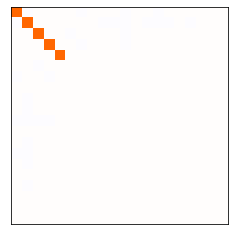

In [14]:
graph_weights(model_0_sparsity.weights)

## Training ReLU Model (0 sparsity)

In [18]:
NUM_EPOCHS = 50
BATCHS_PER_EPOCH = 4000
BATCH_SIZE = 500
LEARNING_RATE = 1e-4

In [19]:
model_0_sparsity_relu = ToyModel(5, 20, True).to(device)

In [20]:
SPARSITY = 0.0
optimizer = torch.optim.SGD(model_0_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_0_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.21245380756950377
(EPOCH: 2) --> loss: 0.07018802813720704
(EPOCH: 3) --> loss: 0.06100640020275116
(EPOCH: 4) --> loss: 0.05253225974559784
(EPOCH: 5) --> loss: 0.04883546530151367
(EPOCH: 6) --> loss: 0.04791476713180542
(EPOCH: 7) --> loss: 0.047712101135253905
(EPOCH: 8) --> loss: 0.04768273363494873
(EPOCH: 9) --> loss: 0.04765415929222107
(EPOCH: 10) --> loss: 0.04763690465450287
(EPOCH: 11) --> loss: 0.04766074620056152
(EPOCH: 12) --> loss: 0.04762640461540222
(EPOCH: 13) --> loss: 0.047651846128463744
(EPOCH: 14) --> loss: 0.04764143036556244
(EPOCH: 15) --> loss: 0.04766468456363678
(EPOCH: 16) --> loss: 0.04764393574810028
(EPOCH: 17) --> loss: 0.047668430057525635
(EPOCH: 18) --> loss: 0.04763409361553192
(EPOCH: 19) --> loss: 0.04765093482494354
(EPOCH: 20) --> loss: 0.04764182009696961
(EPOCH: 21) --> loss: 0.047670030816078186
(EPOCH: 22) --> loss: 0.04766962497043609
(EPOCH: 23) --> loss: 0.04766508667087555
(EPOCH: 24) --> loss: 0.047627664653778

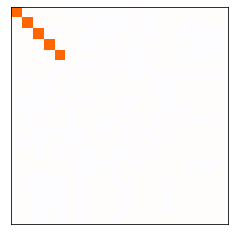

In [21]:
graph_weights(model_0_sparsity_relu.weights)

## Training ReLU Model (70% sparsity)

In [13]:
model_70_sparsity_relu = ToyModel(5, 20, True).to(device)

In [14]:
SPARSITY = 0.70
optimizer = torch.optim.SGD(model_70_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_70_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.21182080697019895
(EPOCH: 2) --> loss: 0.07499559527037045
(EPOCH: 3) --> loss: 0.06742155845766266
(EPOCH: 4) --> loss: 0.0635457372436424
(EPOCH: 5) --> loss: 0.06161941858356198
(EPOCH: 6) --> loss: 0.060376567224413154
(EPOCH: 7) --> loss: 0.058623335732320946
(EPOCH: 8) --> loss: 0.05682082992091775
(EPOCH: 9) --> loss: 0.055961754209796585
(EPOCH: 10) --> loss: 0.055609868921935555
(EPOCH: 11) --> loss: 0.05664401209846139
(EPOCH: 12) --> loss: 0.0567901772112151
(EPOCH: 13) --> loss: 0.05590158065761129
(EPOCH: 14) --> loss: 0.05524404172326128
(EPOCH: 15) --> loss: 0.056506387150337296
(EPOCH: 16) --> loss: 0.055843771949311095
(EPOCH: 17) --> loss: 0.05601373016014695
(EPOCH: 18) --> loss: 0.05593724426120519
(EPOCH: 19) --> loss: 0.05617224360366662
(EPOCH: 20) --> loss: 0.05452145347575347
(EPOCH: 21) --> loss: 0.054580224439501765
(EPOCH: 22) --> loss: 0.05713715182115634
(EPOCH: 23) --> loss: 0.056957238206962746
(EPOCH: 24) --> loss: 0.0561314316572

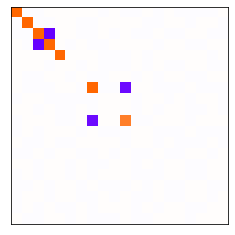

In [15]:
graph_weights(model_70_sparsity_relu.weights)

## Training ReLU Model (90% sparsity)

In [16]:
model_90_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.90
optimizer = torch.optim.SGD(model_90_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_90_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.1285799600426356


In [ ]:
graph_weights(model_90_sparsity_relu.weights)

# Training ReLU Model (97% sparsity)

In [ ]:
model_97_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.97
optimizer = torch.optim.SGD(model_97_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_97_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

In [ ]:
graph_weights(model_97_sparsity_relu.weights)

# Training ReLU Model (99% sparsity)

In [ ]:
model_99_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.99
optimizer = torch.optim.SGD(model_99_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_99_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

In [ ]:
graph_weights(model_99_sparsity_relu.weights)

## Training ReLU Model (99.7 % sparsity)

In [ ]:
model_997_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.997
optimizer = torch.optim.SGD(model_997_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_997_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

In [ ]:
graph_weights(model_997_sparsity_relu.weights)

## Training ReLU Model (99.9 % sparsity)

In [ ]:
model_999_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.999
optimizer = torch.optim.SGD(model_999_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_999_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

In [ ]:
graph_weights(model_999_sparsity_relu.weights)